In [1]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from dsp import *
from dtw import dtw
from tqdm.notebook import trange, tqdm
from numpy.linalg import norm
from copy import deepcopy
from IPython.display import clear_output
import librosa
import os
plt.rcParams['figure.dpi'] = 100

Target sample rate 22050
Generator sample rate 22050


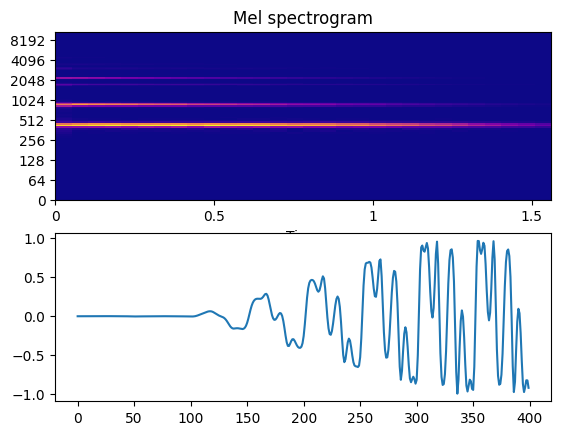

In [2]:
fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

fm_sample = Sample(fm_sample_data)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fm_sample.plot_spectrogram(ax)
ax2.plot(fm_sample.buffer[:400])

fm_sample.show_player()

22050


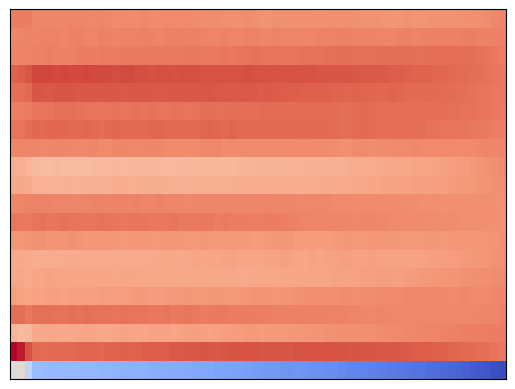

In [3]:
librosa.display.specshow(fm_sample.mfcc)
Audio(data=fm_sample.buffer, rate=SAMPLE_RATE)
print(fm_sample_sample_rate)

2 1 1 0
1 0 1 0
removing


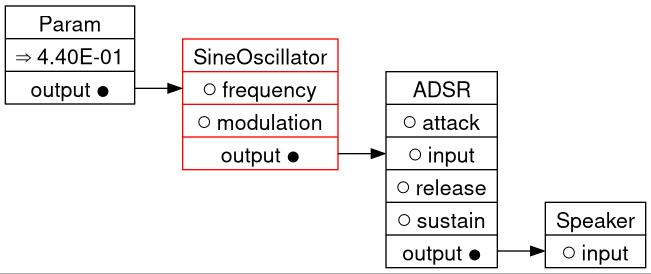

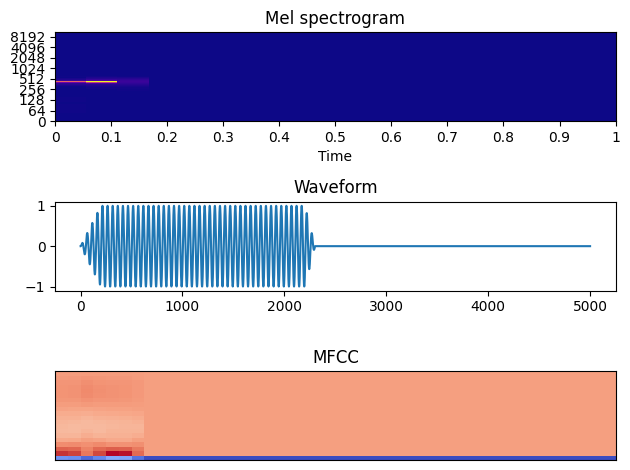

In [4]:
graph = get_starting_graph()

def add_adsr_between(graph: DspGraph, output_node: NodeId, input_node: NodeId) -> Optional[NodeId]:
    for connection in graph.connections:
        print(connection.from_node, connection.to_node, output_node, input_node)
        if connection.from_node == output_node and connection.to_node == input_node:
            print("removing")
            graph.connections.remove(connection)
            break
            
    new_adsr = graph.add_node(ADSR())
    graph.patch( output_node, "output", new_adsr, "input")
    graph.patch(new_adsr, "output", input_node, "input")
    return new_adsr
        
adsr_addr = add_adsr_between(graph, 1, 0)
graph.nodes[adsr_addr].inputs.attack = 0.005
graph.nodes[adsr_addr].inputs.sustain = 0.0005
graph.nodes[adsr_addr].inputs.release = 0.01

display(Image(graph.draw()))

generated_sample = graph.play(SAMPLE_RATE * 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_sample.plot_spectrogram(ax1)
generated_sample.plot_mfcc(ax3)
generated_sample.plot_waveform(ax2, num_samples=5000)
generated_sample.show_player()
fig.tight_layout()

2 1 1 0
1 0 1 0
removing


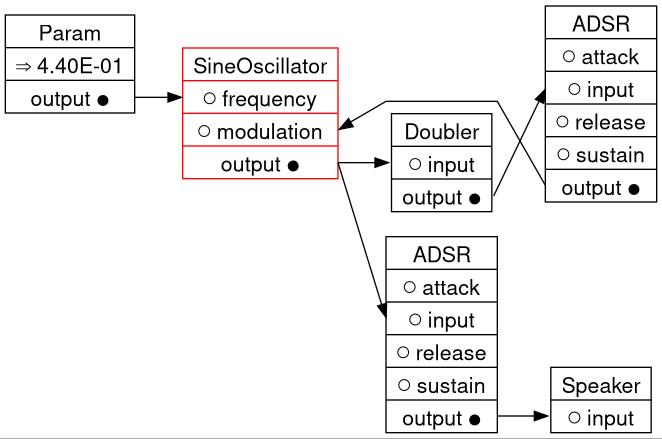

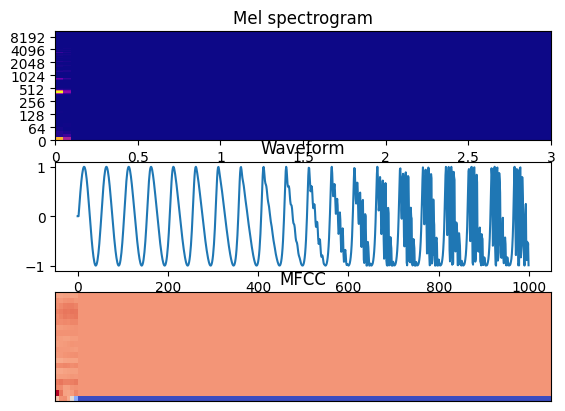

In [5]:
graph = get_starting_graph()

add_adsr_between(graph, 1, 0)


def get_node_of_type(graph, node_type):
    for node_handle, node in graph.nodes.items():
        if isinstance(node, node_type):
            return node_handle

sine = get_node_of_type(graph, SineOscillator)
doubler = graph.add_node(Doubler())
# graph.connections.pop(1)
graph.patch(sine, "output", doubler, "input")
adsr = graph.add_node(ADSR())
graph.patch(doubler, "output", adsr, "input")
graph.patch(adsr, "output", sine, "modulation")

graph.nodes[adsr].inputs.decay =  1
graph.nodes[adsr].inputs.attack =  0.001
graph.nodes[adsr].inputs.release = 0.00001

# graph.patch
# graph.nodes[]
# randomize_random_param(graph)
# randomize_random_param(graph)
# randomize_random_param(graph)
# randomize_random_param(graph)

generated_sample = graph.play(SAMPLE_RATE * 3)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)

generated_sample.plot_spectrogram(ax1)

generated_sample.plot_mfcc(ax3)
generated_sample.plot_waveform(ax2, num_samples=1000)

display(Image(graph.draw()))
generated_sample.show_player()

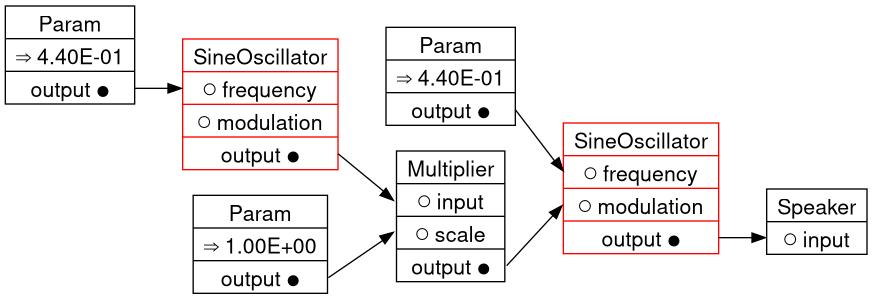

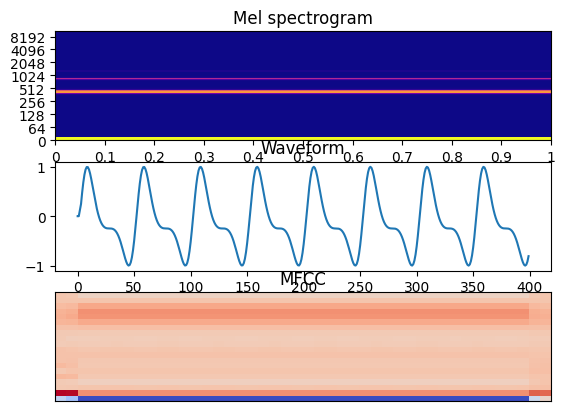

In [6]:
def make_simple_fm(mod_freq, mod_strength) -> DspGraph:
    graph = get_starting_graph()

    modulator = graph.add_node(SineOscillator())
    mod_mult = graph.add_node(Multiplier())

    _mod_freq = Param()
    _mod_scale = Param()
    _mod_scale.set_value(mod_strength)
    _mod_freq.set_value(mod_freq)
    
    mod_freq = graph.add_node(_mod_freq)
    mod_strength = graph.add_node(_mod_scale)

    graph.patch(mod_strength, "output", mod_mult, "scale")
    graph.patch(mod_freq, "output", modulator, "frequency")
    graph.patch(modulator, "output", mod_mult, "input")
    graph.patch(mod_mult, "output", 1, "modulation")

    return graph, mod_strength, mod_freq

graph, mod_strength, mod_freq = make_simple_fm(.440, 1.0)
Image(graph.draw())


generated_audio = graph.play(num_samples = SAMPLE_RATE * 1)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)

generated_audio.plot_spectrogram(ax1)
generated_audio.plot_waveform(ax2)
generated_audio.plot_mfcc(ax3)

display(Image(graph.draw()))
generated_audio.show_player()

target_audio = generated_audio

In [7]:
plus_minus = 4
base = 440
mod_freqs = [ a/1000 for a in range(300, 600, 40) ]
mod_strengths = [ a / 100 for a in range(0, 200, 50) ]

results = np.zeros((len(mod_freqs), len(mod_strengths)))

for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):     
        graph, _, _ = make_simple_fm(freq, mod_strength)
        generated_audio = graph.play(SAMPLE_RATE * 1)
            
        dist = target_audio.mfcc_distance(generated_audio)
        # print(freq, mod_strength, ":", dist)
        
        results[freq_index][mod_index] = dist

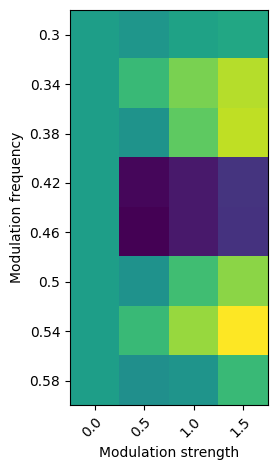

In [8]:
fig, ax = plt.subplots()

im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")

fig.tight_layout()

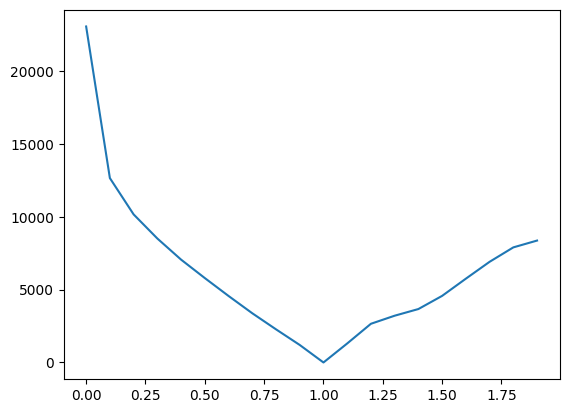

In [9]:
# mod_freqs = [ a/1000 for a in range(400, 600, 40) ]
mod_strengths = [ a / 100 for a in range(0, 200, 10) ]

results = []
for mod_index, mod_strength in enumerate(mod_strengths):
    graph, _, _ = make_simple_fm(.440, mod_strength)

    generated_audio = graph.play(SAMPLE_RATE)
    dist = target_audio.mfcc_distance(generated_audio)

    results.append(dist)
    
plt.plot( mod_strengths, results )

  0%|          | 0/60 [00:00<?, ?it/s]

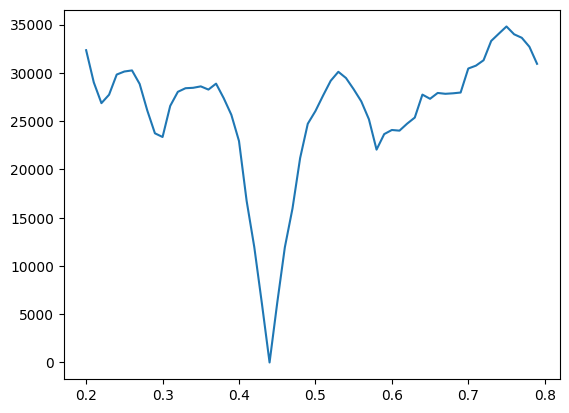

In [10]:
mod_freqs = [ a/1000 for a in range(200, 800, 10) ]

results = []

from multiprocessing import Pool

def get_distance_variable_mod_freq(freq):
    graph, _, _ = make_simple_fm(freq, 1.0)
    generated_audio = graph.play(SAMPLE_RATE)
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_freq, mod_freqs), total=len(mod_freqs)))
    
plt.plot( mod_freqs, results )

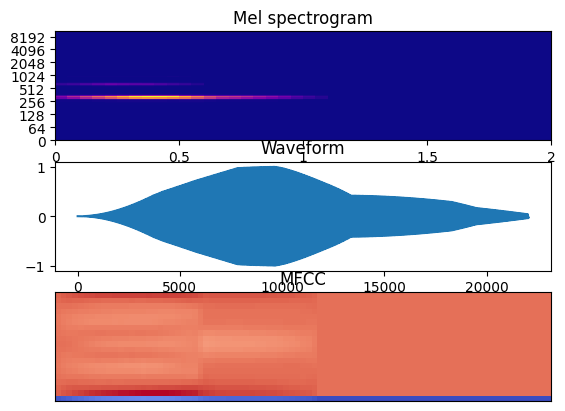

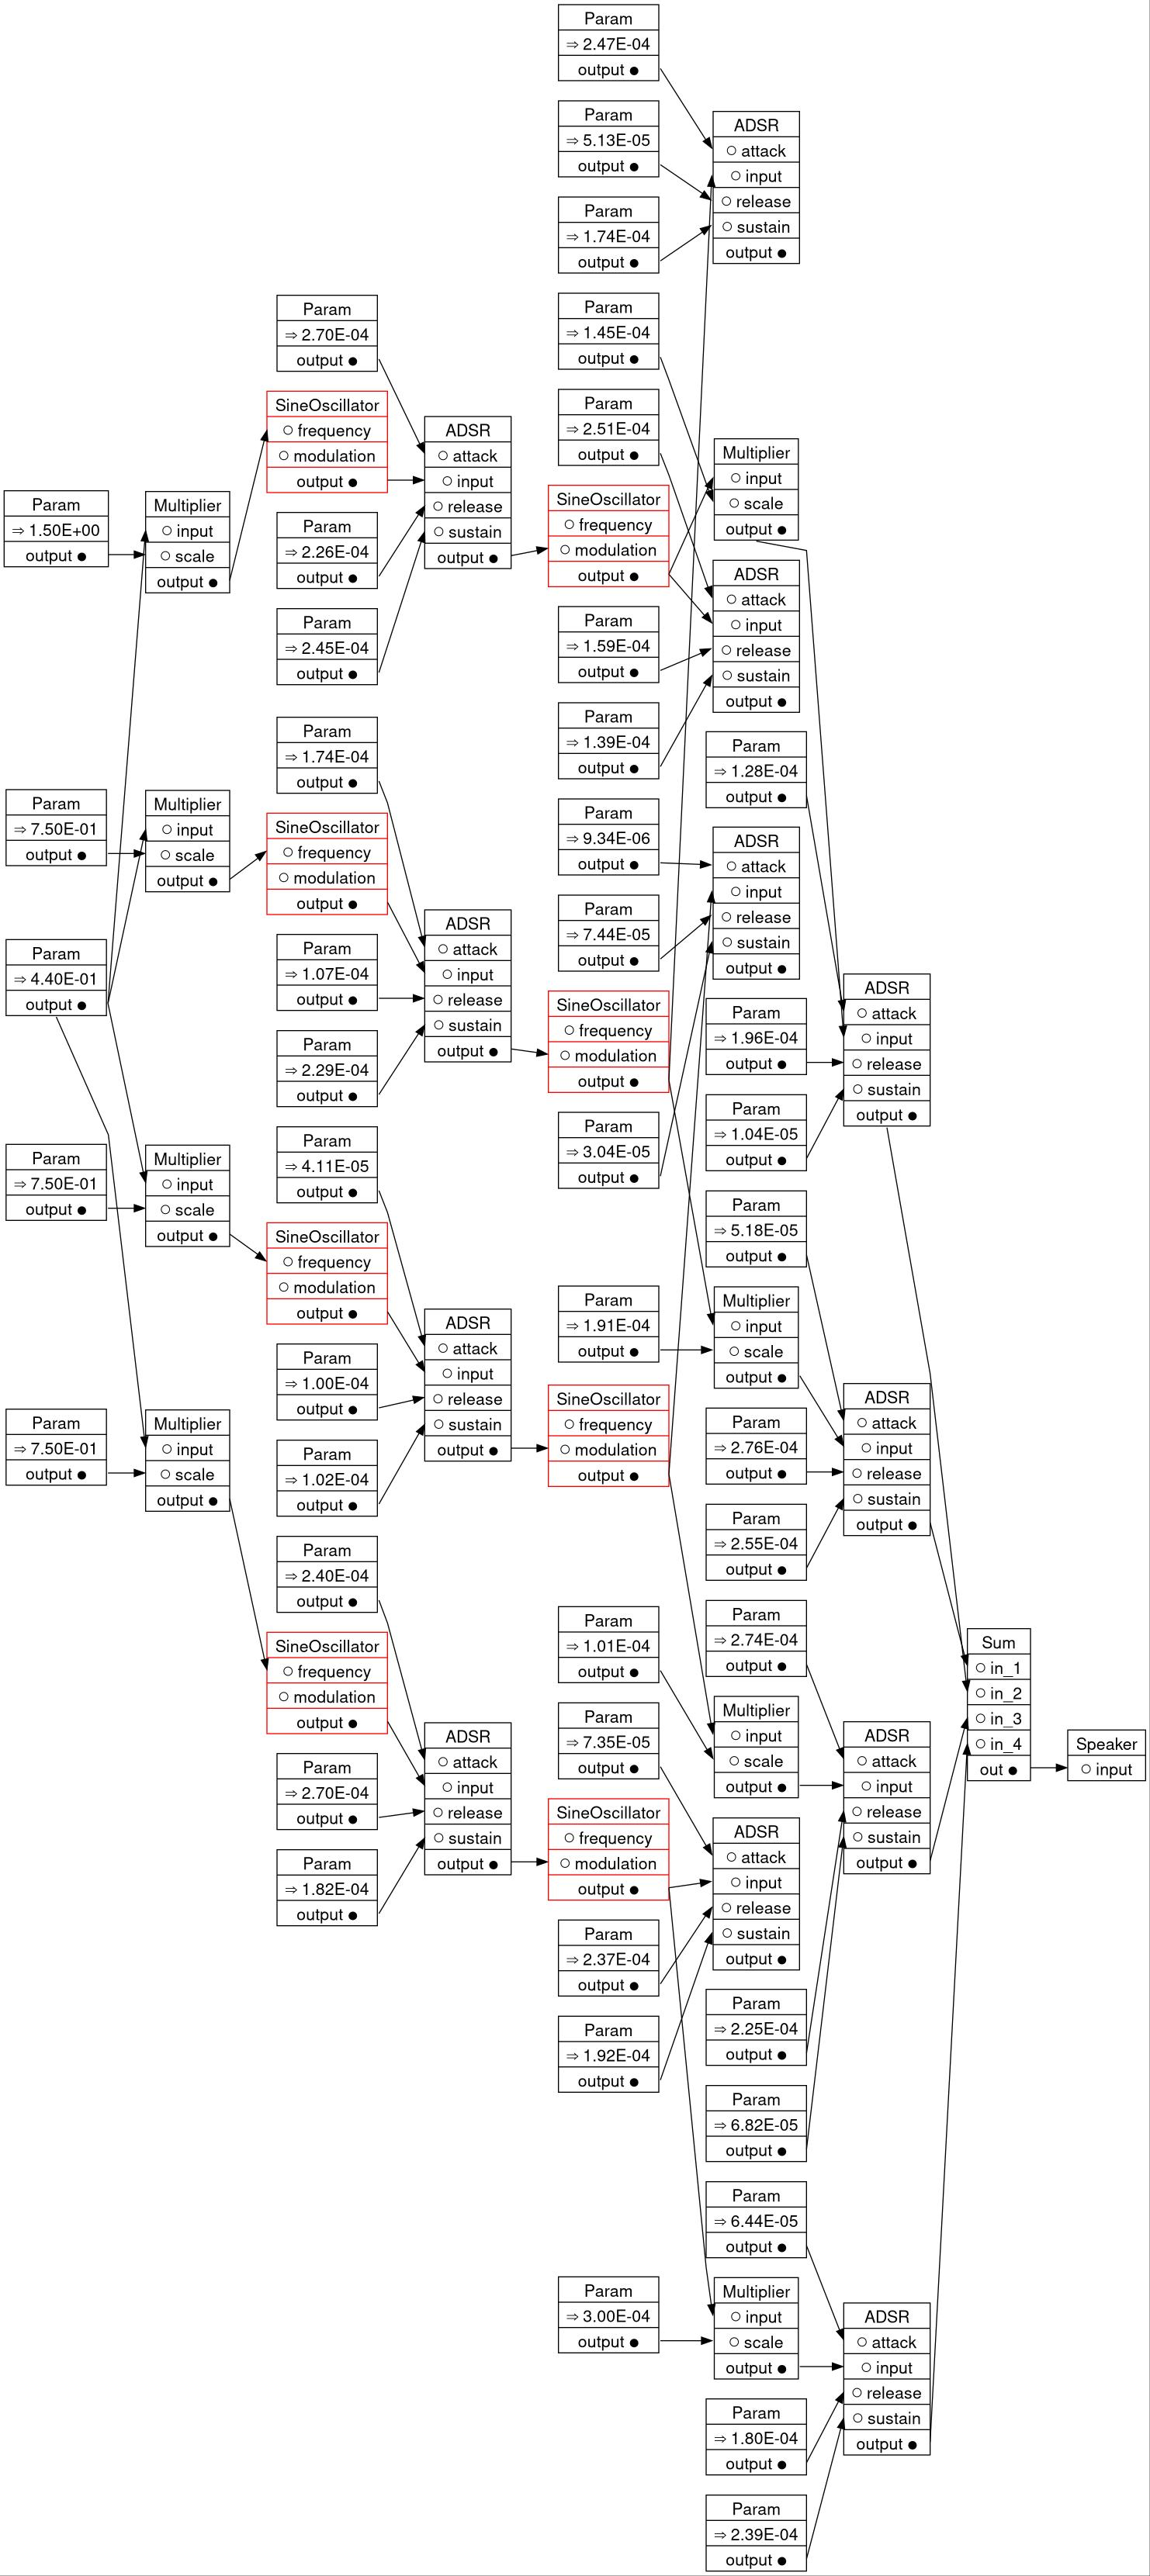

1.0
Distance 48793.28804541954


In [11]:
graph = DspGraph()
param = Param()
param.set_value(.440)
graph.base_frequency_node = graph.add_node(param)

def add_param_random_value(graph: DspGraph):
    param = Param()
    param.set_value(random.uniform(0.0, 0.0003))
    return graph.add_node(param)

def multiplier_with_param(graph: DspGraph):
    mult = graph.add_node(Multiplier())
    param = add_param_random_value(graph)
    graph.patch(param, "output", mult, "scale")
    
    return mult, param

def adsr_with_params(graph: DspGraph):
    adsr = graph.add_node(ADSR())
    
    for input_name in ["attack", "release", "sustain"]:
        param = add_param_random_value(graph)
        graph.patch(param, "output", adsr, input_name)
        
    return adsr

def oscillator_with_multiplier(graph: DspGraph):
    osc = graph.add_node(SineOscillator())
    mod_osc = graph.add_node(SineOscillator())
    
    mod_osc_freq_mult, param = multiplier_with_param(graph)
    graph.nodes[param].set_value(random.choice([0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 1.0, 1.5, 2.0, 2.5]))
    graph.patch(graph.base_frequency_node, "output", mod_osc_freq_mult, "input")
    graph.patch(mod_osc_freq_mult, "output", mod_osc, "frequency")
    
    # graph.patch(graph.base_frequency_node, "output", mod_osc, "frequency")
    
    mod_adsr = adsr_with_params(graph)
    osc_adsr = adsr_with_params(graph)
    
    graph.patch(mod_osc, "output", mod_adsr, "input")
    graph.patch(osc, "output", osc_adsr, "input")
    
    graph.patch(mod_adsr, "output", osc, "modulation")
    mult, param = multiplier_with_param(graph)
    graph.patch(osc, "output", mult, "input")
    return mult


def oscillator_with_adsr(graph: DspGraph):
    mult = oscillator_with_multiplier(graph)
    adsr = adsr_with_params(graph)
    
    graph.patch(mult, "output", adsr, "input")
    
    return adsr
    
mixer = graph.add_node(Sum())
graph.patch(mixer, "out", graph.speaker, "input")


osc_output_node = oscillator_with_adsr(graph)
graph.patch(osc_output_node, "output", mixer, "in_1")

osc_output_node = oscillator_with_adsr(graph)
graph.patch(osc_output_node, "output", mixer, "in_2")

osc_output_node = oscillator_with_adsr(graph)
graph.patch(osc_output_node, "output", mixer, "in_3")

osc_output_node = oscillator_with_adsr(graph)
graph.patch(osc_output_node, "output", mixer, "in_4")

# display(Image(graph.draw()))
generated_audio = graph.play(SAMPLE_RATE * 2)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_audio.plot_spectrogram(ax1)
generated_audio.plot_waveform(ax2, num_samples=SAMPLE_RATE)
generated_audio.plot_mfcc(ax3)
generated_audio.show_player()
plt.show()

display(Image(graph.draw()))

print(max(generated_audio.buffer))

from copy import deepcopy

best_graph = deepcopy(graph)
lowest_dist = fm_sample.mfcc_distance(generated_audio)
print("Distance", lowest_dist)
distances = []

In [12]:
import time


def randomize_calc_distance(changed_graph):
    # for i in range(random.choice[0,1,5,10,15]):
    #     random.choice([
    #         nudge_random_param,
    #         randomize_random_parm,
    #         set_random_param_to_base_frequency,
    #         set_random_param_to_one])(changed_graph)
        
    changed_graph_backup = deepcopy(changed_graph)
    
    generated_sample = changed_graph.play(len(fm_sample))
    if sum(abs(generated_sample.buffer)) == 0:
        dist = 9999999999
        
    dist = fm_sample.mfcc_distance(generated_sample)
    return dist, changed_graph_backup
    
with Pool() as p:
    for i in tqdm(range(1000)):
    
        results = list(p.imap(randomize_calc_distance, [deepcopy(best_graph) for _ in range(8)]))
        
        # results.append(())
        # print(results)
        dist, changed_graph = min(results, key=lambda r: r[0])
        distances.append(dist)

        if dist < lowest_dist:
            best_graph = changed_graph
            lowest_dist = dist
            clear_output()
            print("New best dist", dist)

            # distances.append(dist)
            # import os
            # os.system(f"echo {dist} | tnb")

            graph = deepcopy(best_graph)
            generated_audio = graph.play(SAMPLE_RATE * 2)

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False, sharey=False)
            generated_audio.plot_spectrogram(ax1)
            generated_audio.plot_waveform(ax2, num_samples=800)
            generated_audio.plot_mfcc(ax3)
            generated_audio.show_player()
            ax4.plot(distances)
            fig.tight_layout()
            plt.show()

        # else:
        #     print(i, "nothing new")

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(123)